## Information about the Dataset

The data used in this report relate to the circumstances of road accidents in the UK in 2018. The specific dataset is a subset of the original data retrieved from the UK Department for Transport website. Only a subset of the provided data is being used that provide less complicated information than the original dataset, but at the same time it is as useful for the purposes of this report.

## Business Objective

The goal is to create a parsimonious, adequate and good model that will enable a road assistance company to forecast the number of accidents in the UK __per hour__ and hence allocate its resources accordingly. Hence, the number of accidents will constitute this report's target variable. In doing so, an ARIMA time series model, along with a RandomForest regressor and a support vector regressor will be built and compared in deciding which model is the most accurate in predicting the target variable.

## Load the Data and import the relevant libraries

To begin with, all the relevant libraries that will be used should be imported. Additionally, logging will only print error messages from Sklearnex as sklearn produces a lot of insignificant errors. The Mean Directional Accuracy function is also defined here (its purpose will be further analyzed later in this report).

In [ ]:
# setting logging to print only error messages from Sklearnex
import logging
logging.basicConfig()
logging.getLogger("SKLEARNEX").setLevel(logging.ERROR)

#importing the relevant librarires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

sns.set_theme(palette="Set2")

#Define the Mean Directional Accuracy function
def get_mda(y, yhat):
    """Mean Directional Accuracy, as per:
    https://www.wikiwand.com/en/Mean_Directional_Accuracy
    """
    a = np.sign(np.diff(y))
    b = np.sign(np.diff(yhat))
    return np.sum(a == b)/a.shape[0]

The csv file containing the data will be read onto a pandas dataframe object and the first 5 rows will be print.

In [ ]:
#load the file
df = pd.read_csv('UK Road Accidents 2018.csv')

In [ ]:
#the head method will print the first 5 rows
df.head()

,datetime,Count,Day_of_Week,Precipitation,High_Winds,Road_Surface_Conditions,Light_Conditions,Urban_or_Rural_Area
0,2018-01-01 00:00:00,18,Monday,Fine,False,Dry,Darkness - lights lit,Urban
1,2018-01-01 01:00:00,9,Monday,Fine,False,Wet or damp,Darkness - lights lit,Urban
2,2018-01-01 02:00:00,14,Monday,Fine,False,Wet or damp,Darkness - lights lit,Urban
3,2018-01-01 03:00:00,10,Monday,Fine,False,Wet or damp,Darkness - lights lit,Urban
4,2018-01-01 04:00:00,8,Monday,Fine,False,Dry,Darkness - lights lit,Urban


Using the info method, a glimpse into the data types of each column along with the count of non-null values is achieved. The dataset includes 8540 entries of which none has null values. However, it seems like some times and dates are completely ommited and are not included in the dataset as a year has 365*24= 8760 hours while the dataset includes only 8540 entries. Additionally, the datetime variable's type is a string object. This should be transformed into a datetime object and be set as the index.

In [ ]:
# here the .info() method is applied in order to get some basic information regarding the names of
#the different variables, the total entries and the type of each variable.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8540 entries, 0 to 8539
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   datetime                 8540 non-null   object
 1   Count                    8540 non-null   int64 
 2   Day_of_Week              8540 non-null   object
 3   Precipitation            8540 non-null   object
 4   High_Winds               8540 non-null   bool  
 5   Road_Surface_Conditions  8540 non-null   object
 6   Light_Conditions         8540 non-null   object
 7   Urban_or_Rural_Area      8540 non-null   object
dtypes: bool(1), int64(1), object(6)
memory usage: 475.5+ KB


In [ ]:
# again, no null values are present.
df.isnull().sum()

datetime                   0
Count                      0
Day_of_Week                0
Precipitation              0
High_Winds                 0
Road_Surface_Conditions    0
Light_Conditions           0
Urban_or_Rural_Area        0
dtype: int64

Using the .to_datetime() method and using the datetime variable as input, the string object is transformed into a datetime object

In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [ ]:
df['datetime']

0      2018-01-01 00:00:00
1      2018-01-01 01:00:00
2      2018-01-01 02:00:00
3      2018-01-01 03:00:00
4      2018-01-01 04:00:00
               ...        
8535   2018-12-31 19:00:00
8536   2018-12-31 20:00:00
8537   2018-12-31 21:00:00
8538   2018-12-31 22:00:00
8539   2018-12-31 23:00:00
Name: datetime, Length: 8540, dtype: datetime64[ns]

Datetime is set to be the index of the dataframe object.

In [ ]:
#setting datetime as the index with the set_index method
df.set_index("datetime", inplace = True)

Now, the rows will be reindexed using the .reindex() method. This method will use as an input the range of dates down to hours from 2018-01-01 00:00:00 to 2018-12-31 23:00:00 and set those as the dataset indices. Essentially, in the cases where those indices are already in place, nothing changes, however, when there are missing datetimes, the reindex method will set the columns values as null for the ommited indices. In this manner, I will be able to identify ommitted date times. Because it is fundamental for timeseries analysis that there are no ommited time periods, the null values will need to be filled.

In [ ]:
#here the range of the indices is defined. the freq argument takes 'H' as input, so that the range is set to an
#hourly scale
idx = pd.date_range('2018-01-01', '2018-12-31', freq='H')

In [ ]:
#things seem fine
idx

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 01:00:00',
               '2018-01-01 02:00:00', '2018-01-01 03:00:00',
               '2018-01-01 04:00:00', '2018-01-01 05:00:00',
               '2018-01-01 06:00:00', '2018-01-01 07:00:00',
               '2018-01-01 08:00:00', '2018-01-01 09:00:00',
               ...
               '2018-12-30 15:00:00', '2018-12-30 16:00:00',
               '2018-12-30 17:00:00', '2018-12-30 18:00:00',
               '2018-12-30 19:00:00', '2018-12-30 20:00:00',
               '2018-12-30 21:00:00', '2018-12-30 22:00:00',
               '2018-12-30 23:00:00', '2018-12-31 00:00:00'],
              dtype='datetime64[ns]', length=8737, freq='H')

In [ ]:
#now the reindex method is applied using the idx as inpt
df = df.reindex(idx)

Now the ommited datetimes are visible! There are in total 219 hours in 2018 that have no recorded accidents.

In [ ]:
# the isnull method returns for each row  whether there are any null values. Using the sum method the total
#number of null values for each variable is counted.
df.isnull().sum()

Count                      219
Day_of_Week                219
Precipitation              219
High_Winds                 219
Road_Surface_Conditions    219
Light_Conditions           219
Urban_or_Rural_Area        219
dtype: int64

A good idea to deal with those missing values is to forwardfill the null values. This means taking the value of the previous row and pasting it on the row exactly after it that happens to contain null values. It is important to note that in some cases such as Day_of_week this does not make sense. For example if the previous value for the column Day_of_Week is Monday and the date time is xxxx/xx/xx 23:00:00, the next value does not make sense to be Monday. However, because, only time series analysis will take place here and the only variables that will be used is datetime (the index) and the count of accidents, this won't pose a problem in our case and only the Count variable will be forward filled(for reasons of reusability of code).

In [ ]:
# the ffil method forward fills the null values
df['Count'].ffill(inplace = True)

Sorted. Now, there are no missing values in the data that will be used.

In [ ]:
#non-null values for 'Count'.
df['Count'].isnull().sum()

0

## Train-test split

Before generating descriptive statistics and graphs on the data, it is very import to split the data into a training set and a testing set and then only get insight on the training set. If this is step is ommited, information about the test set might leak in the training set (data leakage) and hence overfitting might occur. If this happens, the generated models might have very good performance in the training and test set but when brought into production, their forecasts could stand far from reality.

In [ ]:
#first import the train_test_split class that will be called to split the data in the train and test set
from sklearn.model_selection import train_test_split

It is important to note here that when train-test splitting the data for time series analysis, the partitions should not be shuffled, but be kept in the original sequence. It is logical that if the partitions are shuffled the forecasts will not make sense as the notion of time is fundamental for timeseries analysis.

In [ ]:
# the split will be done on df, the test set size is set to be 20% of the whole data set , the random_state
#is set to be 7 for reasons of reproducibility of the results and the shuffle is set as False.
train_set, test_set = train_test_split(df, test_size = 0.2, random_state = 7, shuffle = False)

In [ ]:
#Let's have a look at the partitions
print(f'train-set instances: {train_set.shape[0]}, test-set instances: {test_set.shape[0]}')

train-set instances: 6989, test-set instances: 1748


## EDA

Now, it's time to dip into some basic descriptive statistics of the train_set. The mean of hourly accicents is around 14, with a standard deviation of around 10. Additionally, the minimum count of accidents in an hour is 1 and the maximum 62. This means that there is at least 1 accident per hour and at most 62.

In [ ]:
train_set.describe()

,Count
count,6989.000000
mean,13.942481
std,10.353089
min,1.000000
25%,5.000000
50%,12.000000
75%,21.000000
max,62.000000


In order to identify a potential trend or seasonal component in the data, it is usefull to plot the timeseries.

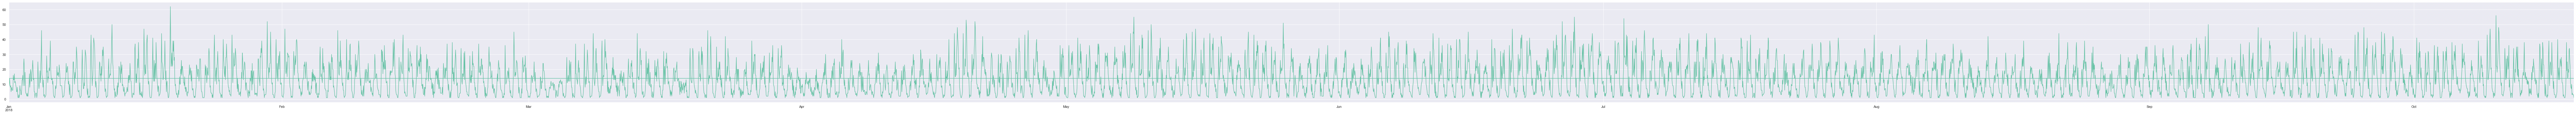

In [ ]:
#here the Count of accidents is plotted vs the date, using the plot method. The figure size is set to be
#quite long so that the plot is not too dense to observe possible patterns. This is done using the figsize argument.
fig = plt.subplot()
train_set['Count'].plot(kind = 'line', figsize = (150, 6))
plt.axhline(y=np.nanmean(train_set['Count']))

There does not seem to be any trend in the timeseries, however, seasonality might be present in a span of only a few hours. The problem here is that the graph is too wide to have a clearer picture and hence, it could be a good idea to break it into monthly pieces.

In [ ]:
#First, a new column will be created, registering the month of each instance. This is done by applying the month
#method on the index
train_set['month']= train_set.index.month

In [ ]:
#Okay, the new column named month is added into the pandas dataframe
#and each month is recorded as a number, i.e. 1 for January, 2 for february and so on and so forth.
train_set

,Count,Day_of_Week,Precipitation,High_Winds,Road_Surface_Conditions,Light_Conditions,Urban_or_Rural_Area,month
2018-01-01 00:00:00,18.0,Monday,Fine,False,Dry,Darkness - lights lit,Urban,1
2018-01-01 01:00:00,9.0,Monday,Fine,False,Wet or damp,Darkness - lights lit,Urban,1
2018-01-01 02:00:00,14.0,Monday,Fine,False,Wet or damp,Darkness - lights lit,Urban,1
2018-01-01 03:00:00,10.0,Monday,Fine,False,Wet or damp,Darkness - lights lit,Urban,1
2018-01-01 04:00:00,8.0,Monday,Fine,False,Dry,Darkness - lights lit,Urban,1
...,...,...,...,...,...,...,...,...
2018-10-19 00:00:00,4.0,Friday,Fine,False,Dry,Darkness - lights lit,Urban,10
2018-10-19 01:00:00,3.0,Friday,Fine,False,Dry,Darkness - no lighting,Rural,10
2018-10-19 02:00:00,3.0,Friday,Fine,False,Dry,Darkness - lights lit,Urban,10
2018-10-19 03:00:00,3.0,Friday,Fine,False,Dry,Darkness - lights lit,Urban,10


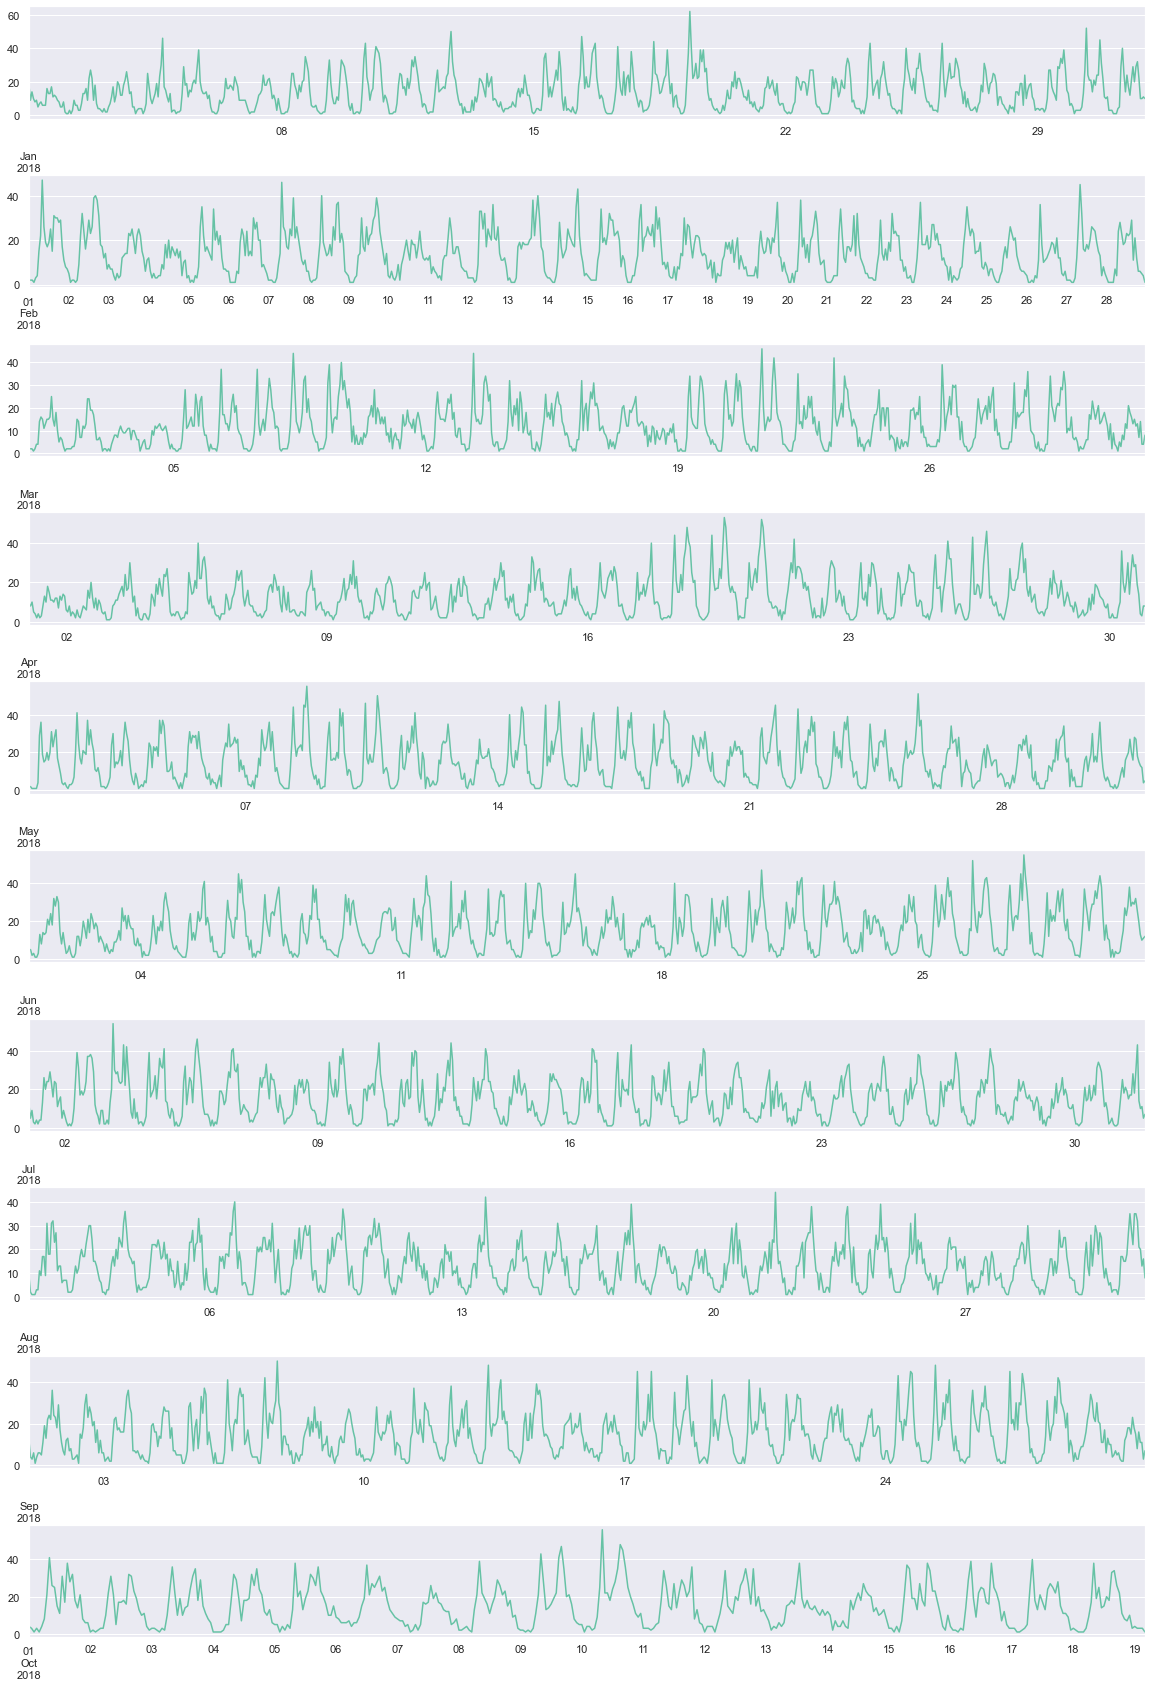

In [ ]:
#first using the subplot method we generate our 'canvas', that will have as many number of rows as the number of
#unique months present in the training set, and 1 column (because the subplots are long more than 1 would make them
# barely visible).
fig, ax = plt.subplots(nrows = len(train_set['month'].unique()), ncols = 1, figsize=(20,30))
#here I adjust the space between them.
fig.subplots_adjust(hspace=.5)
#the for .. in enumerate .. loop bellow will set the value of i as the number of iteration and
#the value of month as the specific value of the column month in the given iteration.
#this will be done as many times as months and for each month 1 plot will be generated that will depict the
#time series for this specific month as dictated by the train_set['month'] == month condition.
#there is no need for legend for the shake of space economy.
for i, month in enumerate(train_set['month'].unique()):
    train_set['Count'].loc[train_set['month'] == month].plot(ax=ax[i], kind = 'line', legend=None)

From the plots above it seems like the timeseries has no trend component, but does contain a seasonality component that is based on an hourly span every day. Simply put in some hours of the day, the count of accidents spikes. This also makes sense intuitively, as during peak times, that more vehicles are on the streets, the count of accidents could be higher. It could be a good idea to zoom further in into any day  and see if that's the case. Additionally, it seems like that in the long run, the timeseries is not stationary as the variance and the mean across time seem to change. This however, should be further explored.

In [ ]:
train_set['day']= train_set.index.day

<AxesSubplot:>

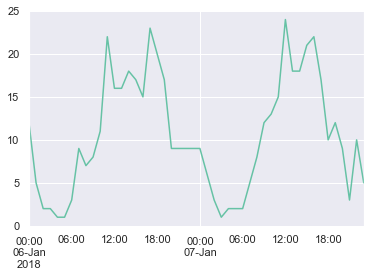

In [ ]:
train_set['Count'].loc[(train_set['month'] == 1) & (train_set['day'] <= 7) & (train_set['day'] >= 6)].plot()

<AxesSubplot:>

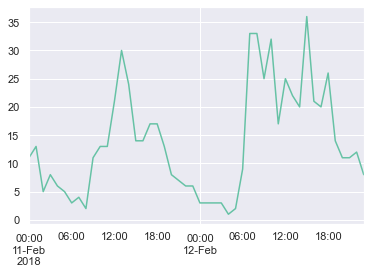

In [ ]:
train_set['Count'].loc[(train_set['month'] == 2) & (train_set['day'] <= 12) & (train_set['day'] >= 11)].plot()

After looking through a couple of examples, it seems like that the accidents number spikes in the busier times of the day (before evening and after dawn), while the number of cases is lower for late evening and early morning.

## Data cleaning and transformation

Before proceeding in building any ARIMA model, it is detrimental that the data is __stationary__. In order to ensure this, the Augmented Dickey-Fuller (ADF) test and the KPSS (Kwiatkowski-Phillips-Schmidt-Shin) tests will test for stationarity (or the lack of it) in the data.

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss

Since, there is no need for all the rest variables, we will only keep 'Count'

In [ ]:
train = train_set['Count']

In [ ]:
train

2018-01-01 00:00:00    18.0
2018-01-01 01:00:00     9.0
2018-01-01 02:00:00    14.0
2018-01-01 03:00:00    10.0
2018-01-01 04:00:00     8.0
                       ... 
2018-10-19 00:00:00     4.0
2018-10-19 01:00:00     3.0
2018-10-19 02:00:00     3.0
2018-10-19 03:00:00     3.0
2018-10-19 04:00:00     1.0
Freq: H, Name: Count, Length: 6989, dtype: float64

We do the same for the test set.

In [ ]:
test = test_set['Count']

In [ ]:
# here the adf test is regressed onto the train set.
adf_pval = adfuller(train, regression="nc")[1]

In [ ]:
#here the kpss test is done onto the train set.
kpss_stat, kpss_pval, lags, crit_vals = kpss(train)

In [ ]:
#The values are ptinted.
print(f' adf p-value : {adf_pval}, kpss p-value: {kpss_pval}')

 adf p-value : 0.13778831501514555, kpss p-value: 0.01


The adf test fails to reject the null hypothesis of non-stationarity (unit root) while the kpss test rejects the null of stationarity. Hence, there is agreement between the two test that the data is __non-stationary__. In order, to make the data stationary, I will try differencing(first difference). This means calculating the difference between the count of accidents between t and t-1 and working on the differenced values instead of the actual count itself.

In [ ]:
train_diff = train.diff()

In [ ]:
train_diff

2018-01-01 00:00:00    NaN
2018-01-01 01:00:00   -9.0
2018-01-01 02:00:00    5.0
2018-01-01 03:00:00   -4.0
2018-01-01 04:00:00   -2.0
                      ... 
2018-10-19 00:00:00    1.0
2018-10-19 01:00:00   -1.0
2018-10-19 02:00:00    0.0
2018-10-19 03:00:00    0.0
2018-10-19 04:00:00   -2.0
Freq: H, Name: Count, Length: 6989, dtype: float64

In [ ]:
#because the first value cannot be differenced (there is no previous value), the result is null. This row should be
#dropped.
train_diff.dropna(inplace=True)

In [ ]:
#here, the adf and kpss tests are regressed onto the differenced data.
adf_pval = adfuller(train_diff, regression="nc")[1]
kpss_stat, kpss_pval, lags, crit_vals = kpss(train_diff)
print(f' adf p-value : {adf_pval}, kpss p-value: {kpss_pval}')

 adf p-value : 0.0, kpss p-value: 0.1


If the adf test and the kpss test is run again, the results are different. The adf test rejects the null hypothesis
of non-stationarity, while the kpss test fails to reject the null hypothesis of stationarity at the 0.05 significance level. __The differenced data is stationary__.

<AxesSubplot:>

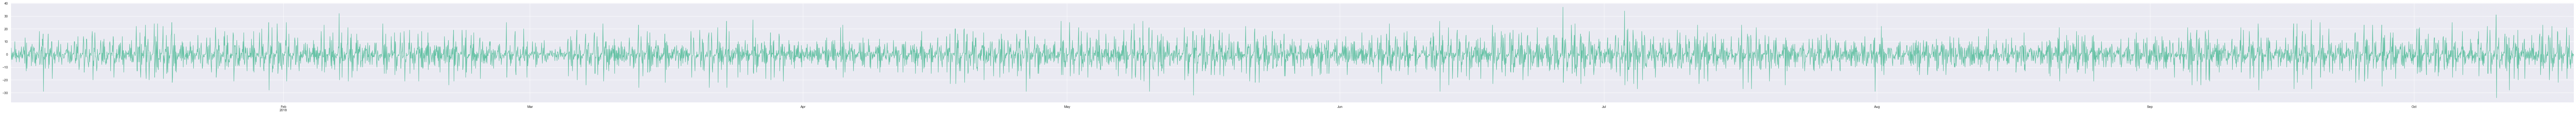

In [ ]:
#plotting the differenced data
train_diff.plot(kind = 'line', figsize = (150, 6))

The differenced data's line graph above also confirms that the data is now stationary. The mean seems to be 0 and the variance constant across time. Now, the test-set data should also be differenced and the first row should be droped.

In [ ]:
test_diff = test.diff().dropna()

## Models building and evaluation

### Baseline models

Two baselines will be created: (a) __a persistence baseline__ and (b) __a mean baseline__ <br/> <br/>
(a) A persistence baseline is essentially the values of all observations transfered one step forward. Those shifted observations are the forecasts for the later ones.<br/>
(b) A mean baseline is simply the mean of the series in the training data and used to predict the values for each observation in the test set.

Baselines are important for understanding where the future models that will be built stand in terms of performance. Simply put, comparing the performance of our models to a baseline model answers the question 'How good is your model in comparison to a very basic simple model?'

### Persistence baseline

In [ ]:
#The shift method transforms the timeseries so that all values are shifted one day forward
test_diff.shift().head()

2018-10-19 06:00:00     NaN
2018-10-19 07:00:00     7.0
2018-10-19 08:00:00     4.0
2018-10-19 09:00:00    29.0
2018-10-19 10:00:00   -20.0
Freq: H, Name: Count, dtype: float64

Because all observations are shifted a day forward, the first day of the new shifted timeseries will be null, hence it should not be included in either of the y and yhat series.

In [ ]:
y = test_diff[1:]
yhat = test_diff.shift()[1:]

In measuring the accuracy of all the models, 3 different measures of accuracy will be used, namely: (a) __RMSE__, (b) __MSE__  and (c) __MDA__. <br/>
More specifically: <br/>
RMSE: measures the root mean squared error.

MSE: measures the mean squared error and will only be used to get the RMSE.

MDA: measures the mean directional accuracy. This measure is useful in understanding to what extent a given model is able in predicting correctly the direction of the change instead of measuring the amount of the error.

In [ ]:
mse = mean_squared_error(y, yhat)
pers_baseline_rmse = np.sqrt(mse)
print(f'mse: {mse}, rmse: {pers_baseline_rmse}')

mse: 121.66036655211913, rmse: 11.029975818292582


In [ ]:
#the get_mda() function has already been defined in code block 3.
pers_baseline_mda = get_mda(y, yhat)
print(f'mda: {pers_baseline_mda}')

mda: 0.2974212034383954


In comparing the model we'll focus on the rmse and mda. The rmse is essentially telling us that the persistence baseline is off by approximately 11 in its predictions, and it was able in predicting correctly the direction of the change (the sign) in the number of accidents around 30% of the times.

### Mean baseline

Now, the mean baseline will be calculated as explained above.

In [ ]:
train_diff_mean = train_diff.mean()
train_diff_mean

-0.002432741843159702

In [ ]:
y = test_diff
yhat = [train_diff_mean]*test_diff.shape[0]

mse = mean_squared_error(y, yhat)
mean_baseline_rmse = np.sqrt(mse)
mean_baseline_rmse

7.711750723476328

In [ ]:
mean_baseline_mda = get_mda(y, yhat)
mean_baseline_mda

0.05326460481099656

The mean baseline performs better in terms of rmse (lower root mean square error) but also has a lower mean directional accuracy (only around 5%).

### ARIMA(p, d, q)

The first forecasting method that will be employed is the Autoregressive integrated moving average (ARIMA).
Essentilly, ARIMA combines 2 models: the AR model (autoregressive model) that tries to predict the target variable using the lags in the autoregressive model. Simply put, it is a multiple linear regression model that predicts the target variable at time t using a linear combination of the timeseries past values. The MA model (Moving average model), functions similarly but instead of using the lags themselves, it uses the forecast error obtained from an autoregressive model.

## p, d and q components

d: this component stands for the number of times the data has been differenced. It is the **order of integration** and in this case it takes the value of 1.

In determining p and q, the __ACF__ and __PACF__ plots will be plotted. The autocorrelation function (ACF) plot and the partial autocorrelation function (PACF) plot, show the correlation between each point in the series yt and yt-k for different values of k. However, the important difference between them is that the PACF plot, as opposed to the ACF plot measures the correlation between yt and yt-k after removing the effects of the in-between lags. In this manner, a lag that seems significant in the ACF plot simply because the intervining lags between that and yt are significant, will seem as insignificant in the PACF plot.

In [ ]:
# the acf and pacf lags are calculated by importing the statsmodels' acf and pacf objects.
from statsmodels.tsa.stattools import acf, pacf
#let's instantiate the acf using the train_diff data and set the number of lags to 20
lag_acf = acf(train_diff, nlags=20)
#let's intantiate the pacf using the train_diff data and set the number of lags to 20
lag_pacf = pacf(train_diff, nlags=20, method='ols')

Text(0.5, 1.0, 'Autocorrelation Function')

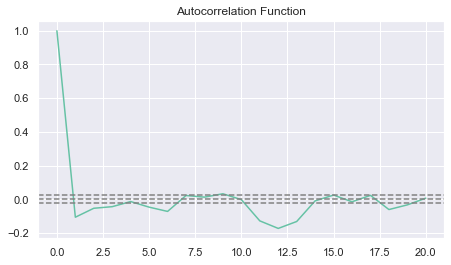

In [ ]:
#plot the acf line graph using plt
plt.figure(figsize=(16,4))

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')


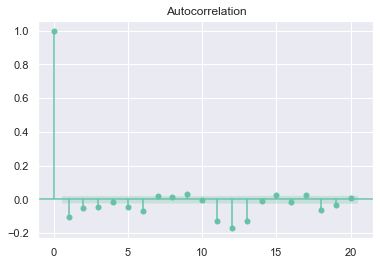

In [ ]:
#a better way to depict the lags is perhaps by using the .plot_acf method of the sm library
sm.graphics.tsa.plot_acf(train_diff.values, lags=20)
plt.show(  )

The lags of the ACF plot suggest that only lags 1,2 and 3 are significant. Some later lags such as lag 5, 6 etc. are also significant or marginally significant, but in order to avoid over-complicating the model, those will not be included. Hence, the value of q = 3

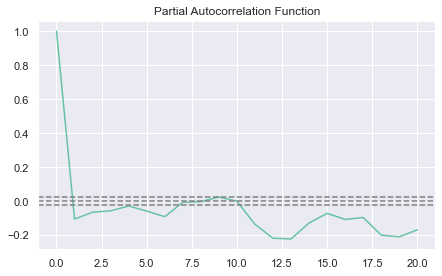

In [ ]:
#Here the pacf is plotted
plt.figure(figsize=(12,4))
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

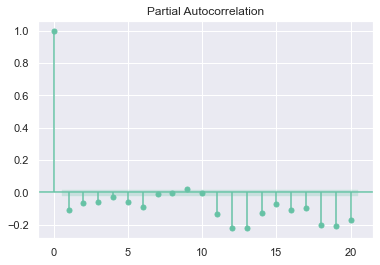

In [ ]:
#And again using the statsmodels library
sm.graphics.tsa.plot_pacf(train_diff.values.squeeze(), lags=20)
plt.show()

The PACF plot also suggests that only lags 1,2 and 3 are significant. After the 10th lag, some lags are also quite significant, but again in order to avoid over-complicating the model, those will also not be included. Hence, the value of p = 3

Hence, in structuring the first ARIMA model, the PACF plot and the ACF plot can give us an idea of what the p and q components should be. The ARIMA model that will be built is ARIMA(3,1,3). Additionally, the dataset does not seem to include any other tiemseries variable that could be included in the model as an exogenous variable(all the other variables are categorical).

In [ ]:
#The ARIMA class is imported from statsmodel
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
#The class is instantiated by passing the train_diff, our endogenous and only variable
#The data is already differenced and hence the d parameter is set to be 0
arima = ARIMA(train_diff, order=(3,0,3)).fit()

In [ ]:
#The summary method summarizes the results
arima.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,0.0002,0.000,1.142,0.254,-0.000,0.001
ar.L1,-0.9495,0.020,-46.596,0.000,-0.989,-0.910
ar.L2,0.3112,0.017,18.345,0.000,0.278,0.344
ar.L3,0.7157,0.014,50.993,0.000,0.688,0.743
ma.L1,0.6775,0.023,29.952,0.000,0.633,0.722
ma.L2,-0.7425,0.012,-63.268,0.000,-0.765,-0.719
ma.L3,-0.9348,0.022,-42.199,0.000,-0.978,-0.891
sigma2,47.7810,0.720,66.341,0.000,46.369,49.193


From the summary of the ARIMA(3,1,3) model above, it seems like all lags of both the AR and the MA parts of the model are significant at the 0.05 significance level.

In [ ]:
# buffers keeping the seen endogenous variable observations and the model's forecast
history_endog = [x for x in train_diff]
predictions = []

# for each test observation
for i, test_obs in enumerate(test_diff):

    # build the ARIMA model and fit it on the current endogenous variable
    model = ARIMA(history_endog, order=(3, 0, 3)).fit()

    #predict the first observation after the trainset
    yhat = model.forecast(steps=1)[0]

    # remember the forecasted value
    predictions.append(yhat)

    # update the buffers for the endogenous variable to also include the true value of the last forecast
    history_endog.append(test_obs)

    print(f'predicted={yhat}, expected={test_obs}')

predicted=3.806221206844315, expected=7.0
predicted=1.3823307032300955, expected=4.0
predicted=0.1370001841684094, expected=29.0
predicted=-6.521514570091219, expected=-20.0
predicted=-1.5586387513676938, expected=-4.0
predicted=-1.0213880096755878, expected=-5.0
predicted=0.09535547016702274, expected=12.0
predicted=-1.8344383094848566, expected=-3.0
predicted=-1.685709829036406, expected=11.0
predicted=-4.155102210321256, expected=21.0
predicted=-9.09997377899977, expected=-18.0
predicted=-4.266513141680274, expected=-4.0
predicted=-5.027305962538982, expected=-1.0
predicted=-4.055151299599366, expected=-20.0
predicted=2.1308801383583926, expected=3.0
predicted=0.1287674816340171, expected=-3.0
predicted=1.333081824799546, expected=-2.0
predicted=1.6098501678579018, expected=0.0
predicted=1.208902394251471, expected=-3.0
predicted=3.147884078624751, expected=-1.0
predicted=2.0284391731283793, expected=-2.0
predicted=4.483358044489541, expected=-1.0
predicted=2.84807266584066, expecte

predicted=0.3830642432336487, expected=-5.0
predicted=2.846576847526946, expected=0.0
predicted=2.5685021124863243, expected=-2.0
predicted=2.212490653642687, expected=-2.0
predicted=4.098090102397914, expected=1.0
predicted=2.3009198186677704, expected=3.0
predicted=2.9766929438858987, expected=4.0
predicted=1.1044137901773, expected=1.0
predicted=1.2311644140125193, expected=4.0
predicted=0.5898292464338332, expected=1.0
predicted=-0.40889523357063134, expected=7.0
predicted=-1.563208144387834, expected=0.0
predicted=-2.011726490908418, expected=4.0
predicted=-2.6348561954423126, expected=-5.0
predicted=-1.4391571670238446, expected=-3.0
predicted=-0.8993917801326993, expected=-1.0
predicted=-0.550210084367748, expected=1.0
predicted=-1.103362771175816, expected=3.0
predicted=-1.3957143628734643, expected=-10.0
predicted=1.1134504267326655, expected=3.0
predicted=-0.06596292002916238, expected=-1.0
predicted=0.5565853099174246, expected=-7.0
predicted=2.3347843688867145, expected=8.0

predicted=-0.02054762075226638, expected=-5.0
predicted=0.9569510283979998, expected=-4.0
predicted=2.2718651433086117, expected=3.0
predicted=1.2467655279415464, expected=-3.0
predicted=2.3124296840589866, expected=-3.0
predicted=2.796585089909552, expected=1.0
predicted=2.417589606952894, expected=-2.0
predicted=3.294288969359998, expected=-2.0
predicted=3.4622363619779044, expected=2.0
predicted=3.3913158034289976, expected=4.0
predicted=2.006516262718386, expected=-6.0
predicted=3.668172504981324, expected=7.0
predicted=1.6969600974805665, expected=5.0
predicted=0.557100204350399, expected=-2.0
predicted=1.0079297041813062, expected=4.0
predicted=0.04751006737548704, expected=1.0
predicted=-0.006867369725229126, expected=-3.0
predicted=0.7205136121189389, expected=4.0
predicted=-0.2707657546193139, expected=-2.0
predicted=0.7046925248145143, expected=0.0
predicted=-0.057372664907043965, expected=3.0
predicted=-0.5089674966407164, expected=-10.0
predicted=2.2448270391577285, expecte

predicted=-2.7132222824980934, expected=-7.0
predicted=0.06352726818136345, expected=-6.0
predicted=0.7269411259695744, expected=-1.0
predicted=1.16832554333984, expected=1.0
predicted=0.9913884635723965, expected=-6.0
predicted=2.5568511666640847, expected=-1.0
predicted=3.024099747531855, expected=-1.0
predicted=2.324599948518463, expected=-2.0
predicted=4.004967825904142, expected=3.0
predicted=2.638353159930888, expected=0.0
predicted=2.812521546895403, expected=-3.0
predicted=3.5846094947671157, expected=4.0
predicted=2.4158799454577675, expected=5.0
predicted=1.3890099175408883, expected=7.0
predicted=-0.6176513797439671, expected=30.0
predicted=-8.11444245713367, expected=-16.0
predicted=-3.458271832063801, expected=-8.0
predicted=-2.472843508146577, expected=-7.0
predicted=-0.04357556083329661, expected=2.0
predicted=-0.5105676682069982, expected=7.0
predicted=-2.6630412208839536, expected=4.0
predicted=-2.606651668818166, expected=-2.0
predicted=-3.1822588607538185, expected=-

predicted=-2.1279058523698517, expected=-6.0
predicted=-0.2677872350881807, expected=8.0
predicted=-2.315090300515173, expected=10.0
predicted=-4.8524654787225865, expected=3.0
predicted=-5.288492567726178, expected=-1.0
predicted=-5.6009693378623995, expected=-17.0
predicted=-0.860907126150345, expected=-8.0
predicted=0.8261328560624881, expected=-3.0
predicted=1.5552110607788334, expected=-7.0
predicted=3.8736076100240706, expected=0.0
predicted=3.0455359844129837, expected=1.0
predicted=3.371787519179884, expected=0.0
predicted=2.899120250537852, expected=-2.0
predicted=3.6080571741510177, expected=0.0
predicted=3.6434618907279845, expected=0.0
predicted=3.462036660625177, expected=1.0
predicted=3.4070572285009724, expected=8.0
predicted=0.8778402660769368, expected=0.0
predicted=1.4641239076689865, expected=25.0
predicted=-5.2297320813424655, expected=-5.0
predicted=-3.4269699996874627, expected=-18.0
predicted=1.7422155503394647, expected=11.0
predicted=-2.570814425454592, expecte

predicted=1.251725181494231, expected=2.0
predicted=0.15981817700088655, expected=0.0
predicted=0.5289132241663961, expected=-1.0
predicted=0.5225296548649976, expected=5.0
predicted=-0.5330889228128045, expected=8.0
predicted=-2.6908755373624174, expected=5.0
predicted=-3.910363590963448, expected=24.0
predicted=-9.343170352762396, expected=5.0
predicted=-10.511111841115364, expected=-11.0
predicted=-7.945103361059213, expected=-32.0
predicted=0.05686884762864141, expected=-5.0
predicted=0.933572845794125, expected=-1.0
predicted=0.9988607639267979, expected=-3.0
predicted=2.1192571275726286, expected=-1.0
predicted=1.8946382972725198, expected=-2.0
predicted=2.7177035796409528, expected=-3.0
predicted=3.4001473126441595, expected=1.0
predicted=3.0362735569527546, expected=-2.0
predicted=3.662332232450479, expected=2.0
predicted=3.2143822818318566, expected=3.0
predicted=2.349514011201767, expected=8.0
predicted=0.3632254897002173, expected=18.0
predicted=-4.287647465315168, expected=

predicted=2.5265242356372983, expected=-2.0
predicted=2.8702665140465156, expected=7.0
predicted=0.9737432022799328, expected=33.0
predicted=-6.943103677797725, expected=-7.0
predicted=-5.27259070488284, expected=-14.0
predicted=-2.2090773118721887, expected=-11.0
predicted=0.6977034288158637, expected=12.0
predicted=-1.8549002377342008, expected=-8.0
predicted=-0.18285509789212193, expected=-6.0
predicted=1.1598604626845894, expected=3.0
predicted=0.6994859897799371, expected=23.0
predicted=-5.142224205659195, expected=6.0
predicted=-6.809518211283562, expected=16.0
predicted=-10.413062729693424, expected=-24.0
predicted=-4.305535815331945, expected=-16.0
predicted=-0.3474920565787668, expected=-7.0
predicted=1.1448650103960525, expected=2.0
predicted=0.9122478577974021, expected=-3.0
predicted=1.3734473099436995, expected=-7.0
predicted=3.318169720976865, expected=2.0
predicted=2.527323545442934, expected=-4.0
predicted=3.752956924326824, expected=3.0
predicted=2.644764528731403, exp

predicted=3.317688482161638, expected=-1.0
predicted=3.3111236370851325, expected=1.0
predicted=3.21282424026586, expected=-1.0
predicted=3.3521235769456763, expected=0.0
predicted=3.3742983692374406, expected=1.0
predicted=3.169920524751086, expected=2.0
predicted=2.351142276772309, expected=4.0
predicted=1.7155238075768848, expected=20.0
predicted=-3.4279483916174422, expected=2.0
predicted=-3.636476569970509, expected=-14.0
predicted=-0.2520933109041723, expected=-5.0
predicted=0.899912833043795, expected=9.0
predicted=-1.3391775335643064, expected=-8.0
predicted=0.6660878745070391, expected=2.0
predicted=0.17740714434434465, expected=2.0
predicted=-0.40380552511962925, expected=15.0
predicted=-4.044091407018522, expected=1.0
predicted=-4.350033997006556, expected=12.0
predicted=-7.293468889538792, expected=-7.0
predicted=-5.544011530301008, expected=-19.0
predicted=-0.5898923751338455, expected=-5.0
predicted=0.33112215833388936, expected=-6.0
predicted=1.9893955383278705, expected

predicted=0.20108004939079746, expected=3.0
predicted=-0.5729272868038907, expected=-11.0
predicted=2.1628495105648646, expected=3.0
predicted=1.2992328950006096, expected=-4.0
predicted=2.4501840242722412, expected=0.0
predicted=2.2241058038130634, expected=-1.0
predicted=2.6512517006083893, expected=0.0
predicted=2.521051994894863, expected=-3.0
predicted=3.3583789433631472, expected=-1.0
predicted=3.624941389964321, expected=6.0
predicted=2.0915753529005707, expected=4.0
predicted=1.146656490898626, expected=1.0
predicted=0.7091769493516789, expected=2.0
predicted=0.39250447094249813, expected=0.0
predicted=0.31421719353924077, expected=0.0
predicted=0.5081084219426096, expected=-2.0
predicted=0.924439588035033, expected=10.0
predicted=-1.522824871398124, expected=5.0
predicted=-2.891471370377, expected=-8.0
predicted=-0.7902270456023798, expected=5.0
predicted=-2.0406559166361125, expected=6.0
predicted=-3.537359871702887, expected=3.0
predicted=-4.236869431636182, expected=-1.0
pr

predicted=-2.0130208726532417, expected=-3.0
predicted=-1.0652367126736777, expected=-2.0
predicted=-0.7422368113705822, expected=-3.0
predicted=0.06357107260647489, expected=-7.0
predicted=1.7778176785683397, expected=0.0
predicted=1.725326538123554, expected=-1.0
predicted=2.019967231018028, expected=2.0
predicted=1.4869847207818692, expected=-5.0
predicted=2.7690744887901637, expected=1.0
predicted=2.5171500409666954, expected=-1.0
predicted=2.738019499889901, expected=-3.0
predicted=3.354845176667295, expected=0.0
predicted=3.44753960856257, expected=0.0
predicted=3.3497278028853144, expected=0.0
predicted=3.308878395801427, expected=4.0
predicted=2.494341764532352, expected=-2.0
predicted=2.994389014547838, expected=1.0
predicted=2.737750047055032, expected=1.0
predicted=2.4837884242515273, expected=5.0
predicted=1.2224281650668247, expected=10.0
predicted=-1.250342774036596, expected=-4.0
predicted=-0.0645060004529054, expected=0.0
predicted=-0.44888503449866063, expected=-7.0
pr

<AxesSubplot:>

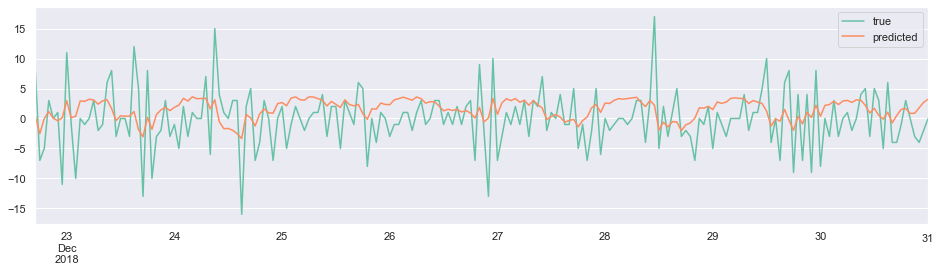

In [ ]:
#plot the predicted values and the true values line chart. For a clearer picture I take the last 200 observations
pd.DataFrame({"true": test_diff[-200:], "predicted": predictions[-200:]}
            ).plot(figsize=(16, 4))

It seems like ARIMA(3,1,3) model matches the true peaks and drops of the timeseries in most cases, however, the forecasted values are quite modest in comparison to the true values.  

In [ ]:
#calculate the mse and use it to calculate the rmse
mse = mean_squared_error(test_diff, predictions)
arima_rmse = np.sqrt(mse)
arima_rmse

7.245061212925325

In [ ]:
#calculate the mse and use it to calculate the rmse
mse = mean_squared_error(test_diff, predictions)
arima_rmse = np.sqrt(mse)
arima_rmse

7.245061212925325

In [ ]:
#calculate the mda
arima_mda = get_mda(test_diff, predictions)
arima_mda

0.7153493699885453

The rmse and the mda have improved quite a bit compared to the baseline models.

# Machine learning methods

Next, machine learning models will be built in an endeavor to forecast the values of future car accidents. Perhaps, such models could provide forecasts of even higher accuracy (rmse and mda). More specifically, 2 popular supervised regression algorithms will be used: a Random forest and a SVM regressor.  

First the data has to be restructured so they can be inputed in the ML algorithms. More specifically, the rows contain instances, while columns contain the lagged values of each target.

In [ ]:
#The create_ar_vars variable that is used takes as an input the training or test set and the number of lags
def create_ar_vars(ts, lags):
    """Create autoregressive X variables
    """
#buffers for predictors and target
    X, y = [], []

#in each iteration append to list X an array that includes the lags and in list y an array of the instance
    for i in range(len(ts)-lags):
        X.append(ts[i:i + lags, 0])
        y.append(ts[i + lags, 0])
# convert the lists into numpy arrays
    return np.array(X), np.array(y)

Now the create_ar_vars function is instantiated and the train and test data are reshaped so that they can be fed in the ML algorithms. the Xtrain contains the predictor and the ytrain the targets for the training set. The test set has been reformed accordingly.

In [ ]:
#the create_ar_vars is instantiated using the train_diff and test_diff values after they have been reshaped so
#that each row contains 1 instance
Xtrain, ytrain = create_ar_vars(train_diff.values.reshape(-1, 1), lags=3)
Xtest, ytest = create_ar_vars(test_diff.values.reshape(-1, 1), lags=3)

The predictor variable must be standardized by removing the mean and scaling to unit variance.

In [ ]:
#StandardScaler class is imported from the sklearn library
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

#The Xtrain predictors are fitted and transformed using the standard scaler.
Xtrain = scaler.fit_transform(Xtrain)

#The Xtest predictors are transofmed based on the previously fitted data on the Xtrain, to avoid data leakage.
Xtest = scaler.transform(Xtest)

In order to tune the hyperparameters using GridSearchCV, the TimeSeriesSplit class from sklearn is used to split the data in training and validation sets, while maintaining the order. Hence the cross-validation technique cannot be used, and instead the TimeSeriesSplit class splits the data in such a manner so that the training sets preceed each validation set. Bellow, the subplots demonstrate how those splits are done.

Full training set size: 6985

Split 1
Observations: 2329
Training Observations: 1165
Validation Observations: 1164
Split 2
Observations: 3493
Training Observations: 2329
Validation Observations: 1164
Split 3
Observations: 4657
Training Observations: 3493
Validation Observations: 1164
Split 4
Observations: 5821
Training Observations: 4657
Validation Observations: 1164
Split 5
Observations: 6985
Training Observations: 5821
Validation Observations: 1164


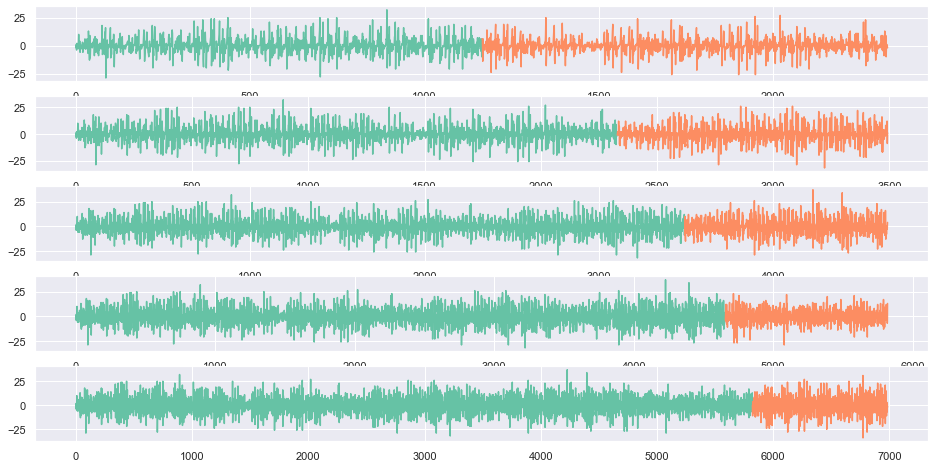

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

tscv = TimeSeriesSplit(n_splits=5)
plt.figure(figsize=(16, 8))
plt.figure(1)
print(f"Full training set size: {Xtrain.shape[0]}\n")
index = 1


for train_index, test_index in tscv.split(Xtrain):
    train = ytrain[train_index]
    test = ytrain[test_index]
    obs = len(train) + len(test)
    print(f'Split {index}')
    print(f'Observations: {obs}')
    print(f'Training Observations: {len(train)}')
    print(f'Validation Observations: {len(test)}')
    plt.subplot(510 + index)
    plt.plot(train)
    plt.plot([None for i in train] +
                 [x for x in test] +
                 [None for i in range(obs, Xtrain.shape[0])])
    index += 1

## Random Forest Regressor

Now, the data are ready to be inserted to a RandomForest regressor. Again, using GridSearchCV, while making sure that the cross-validation sets are structured using the TimeSeriesSplit, the hyperparameters of the RandomForest can be adjusted to optimize performance. More specifically, 2 hyperparameters will be taken into account: <br/> <br/>
(a) __number of estimators__, that is the number of trees built to predict the target variable <br/>
(b) __max_depth__, that is the highest number of splits in each decision tree that is allowed. <br/> <br/>
Those two hyperparameters, if adjusted can lead to a model with higher performance.

In [ ]:
%%time

from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=7)

#Sklearn default value of n_estimators is 100. I will try a few less and a few more than that
#At the same time I set the max_depth values that will be cross validated
param_grid = [
    {'n_estimators': [2, 3, 5, 10, 20, 50, 100, 120],
     'max_depth': [2, 4, 6, 8, 10, None]},
]

tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(estimator=forest_reg, cv=tscv,
                        param_grid=param_grid,
                        scoring='neg_root_mean_squared_error',
                        return_train_score=True)
grid_search.fit(Xtrain, ytrain)

CPU times: user 21.7 s, sys: 253 ms, total: 21.9 s
Wall time: 21.9 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(random_state=7),
             param_grid=[{'max_depth': [2, 4, 6, 8, 10, None],
                          'n_estimators': [2, 3, 5, 10, 20, 50, 100, 120]}],
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [ ]:
-grid_search.best_score_

6.714282897796352

In [ ]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score',
                                                    'mean_test_score']]
cv_results["mean_train_score"] = -cv_results["mean_train_score"]
cv_results["mean_test_score"] = -cv_results["mean_test_score"]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

cv_results.sort_values('mean_test_score')

,params,mean_train_score,mean_test_score,"diff, %"
23,"{'max_depth': 6, 'n_estimators': 120}",6.123554,6.714283,-9.646828
22,"{'max_depth': 6, 'n_estimators': 100}",6.122228,6.717725,-9.726798
21,"{'max_depth': 6, 'n_estimators': 50}",6.125462,6.722671,-9.749614
30,"{'max_depth': 8, 'n_estimators': 100}",5.713481,6.735758,-17.892383
31,"{'max_depth': 8, 'n_estimators': 120}",5.716506,6.736018,-17.834532
20,"{'max_depth': 6, 'n_estimators': 20}",6.140293,6.740781,-9.779474
29,"{'max_depth': 8, 'n_estimators': 50}",5.720206,6.752161,-18.040512
13,"{'max_depth': 4, 'n_estimators': 50}",6.449497,6.768190,-4.941369
12,"{'max_depth': 4, 'n_estimators': 20}",6.462889,6.770500,-4.759649
14,"{'max_depth': 4, 'n_estimators': 100}",6.449088,6.771339,-4.996836


The best mean_rmse for the validation set is around 6.71 for a max depth of 6 and a number of estimators 120. Perhaps, further adjusting the hyperparameters for values around 120 and 6, might increase the performance slightly more.

In [ ]:
param_grid = [
    {'n_estimators': [100, 110, 120, 130, 140, 150],
     'max_depth': [5, 6, 7]},
]

grid_search = GridSearchCV(estimator=forest_reg, cv=tscv,
                        param_grid=param_grid,
                        scoring='neg_root_mean_squared_error',
                        return_train_score=True)
grid_search.fit(Xtrain, ytrain)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(random_state=7),
             param_grid=[{'max_depth': [5, 6, 7],
                          'n_estimators': [100, 110, 120, 130, 140, 150]}],
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [ ]:
-grid_search.best_score_

6.714282897796352

In [ ]:
cv_results.sort_values('mean_test_score')

,params,mean_train_score,mean_test_score,"diff, %"
23,"{'max_depth': 6, 'n_estimators': 120}",6.123554,6.714283,-9.646828
22,"{'max_depth': 6, 'n_estimators': 100}",6.122228,6.717725,-9.726798
21,"{'max_depth': 6, 'n_estimators': 50}",6.125462,6.722671,-9.749614
30,"{'max_depth': 8, 'n_estimators': 100}",5.713481,6.735758,-17.892383
31,"{'max_depth': 8, 'n_estimators': 120}",5.716506,6.736018,-17.834532
20,"{'max_depth': 6, 'n_estimators': 20}",6.140293,6.740781,-9.779474
29,"{'max_depth': 8, 'n_estimators': 50}",5.720206,6.752161,-18.040512
13,"{'max_depth': 4, 'n_estimators': 50}",6.449497,6.768190,-4.941369
12,"{'max_depth': 4, 'n_estimators': 20}",6.462889,6.770500,-4.759649
14,"{'max_depth': 4, 'n_estimators': 100}",6.449088,6.771339,-4.996836


The best estimator remains the same. No further performance improvement was achieved.

In [ ]:
RF_best = grid_search.best_estimator_

## Support Vector Regressor

The last method that will be applied is  a support vector regressor. Similar to a regression line, a hyperplane( a line exceeding 3 dimensions) will be developed but instead of endeavoring to minimize the error, it will try to contain it within some specified margins of tolerance (ε) where no penalty is given to errors. In building the support vector regressor, various values of epsilon will be tested (smaller for a stricter model with less errors and larger for a softer model, with larger errors).  However, if ε is too small, a model tends to overfit, whereas if it is too large, it tends to underfit. Hence, ε values of 0.001 and 0.01 will be tested. Additionally, C, the penalty term for errors exceeding the margins of tolerance, will be set to take a few different values. In general the larger the C parameter's value the lower missclassification is, but higher the chances of overfitting. The hyperparameter gamma will be left as default (scale). In general, a support vector regressor is a quite popular algorithm, especially if data are lineary seperable, however, the downside is that it takes longer to be executed.

In [ ]:
%%time

from sklearn.svm import SVR

svr = SVR(kernel="rbf")
param_grid = [
        {
            "C": [0.001, 0.005, 0.01, 0.05, 0.1, 1.0, 5.0],
            "epsilon": [0.001, 0.01],
        }
]

tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(estimator=svr, cv=tscv,
                        param_grid=param_grid,
                        scoring='neg_root_mean_squared_error',
                        return_train_score=True)
grid_search.fit(Xtrain, ytrain)

CPU times: user 3min 26s, sys: 2.28 s, total: 3min 28s
Wall time: 3min 29s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=SVR(),
             param_grid=[{'C': [0.001, 0.005, 0.01, 0.05, 0.1, 1.0, 5.0],
                          'epsilon': [0.001, 0.01]}],
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [ ]:
-grid_search.best_score_

6.7028853225491485

In [ ]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["mean_train_score"] = -cv_results["mean_train_score"]
cv_results["mean_test_score"] = -cv_results["mean_test_score"]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

cv_results.sort_values('mean_test_score')

,params,mean_train_score,mean_test_score,"diff, %"
12,"{'C': 5.0, 'epsilon': 0.001}",6.454215,6.702885,-3.852832
13,"{'C': 5.0, 'epsilon': 0.01}",6.453955,6.703144,-3.861027
10,"{'C': 1.0, 'epsilon': 0.001}",6.586321,6.774018,-2.849799
11,"{'C': 1.0, 'epsilon': 0.01}",6.586313,6.774040,-2.850257
9,"{'C': 0.1, 'epsilon': 0.01}",6.923872,7.031539,-1.555021
8,"{'C': 0.1, 'epsilon': 0.001}",6.924146,7.031774,-1.554379
6,"{'C': 0.05, 'epsilon': 0.001}",7.006043,7.097855,-1.310475
7,"{'C': 0.05, 'epsilon': 0.01}",7.006454,7.098354,-1.311645
5,"{'C': 0.01, 'epsilon': 0.01}",7.129900,7.197099,-0.942501
4,"{'C': 0.01, 'epsilon': 0.001}",7.130098,7.197374,-0.943555


In [ ]:
SVR = grid_search.best_estimator_

The best estimator is that where C = 5 and epsilon = 0.001. This model has a mean_test_score of approximately 6.70 and seems promising.

## Evaluate models on the test set

For the Support Vector Regressor:

In [ ]:
yhat = SVR.predict(Xtest)

svr_mse = mean_squared_error(ytest, yhat)
svr_rmse = np.sqrt(svr_mse)

svr_mda = get_mda(ytest, yhat)

For the RandomForest Regressor:

In [ ]:
yhat = RF_best.predict(Xtest)

rf_mse = mean_squared_error(ytest, yhat)
rf_rmse = np.sqrt(rf_mse)
rf_rmse

rf_mda = get_mda(ytest, yhat)

# Summary and future suggestions

## RMSE table

In [ ]:
rmse_table = pd.DataFrame({
    'method': ['Persistence baseline', 'Mean baseline', 'ARIMA', 'SVR', 'RandomForest'],
    'RMSE': [pers_baseline_rmse, mean_baseline_rmse, arima_rmse, svr_rmse, rf_rmse],
})

rmse_table.set_index("method", inplace=True)

# add columns with percent changes on the baselines
rmse_table['% Change on Pers. baseline'] = 100 * (rmse_table['RMSE'] / pers_baseline_rmse) - 100
rmse_table['% Change on Mean baseline'] = 100 * (rmse_table['RMSE'] / mean_baseline_rmse) - 100

rmse_table

,RMSE,% Change on Pers. baseline,% Change on Mean baseline
method,,,
Persistence baseline,11.029976,0.000000,43.028168
Mean baseline,7.711751,-30.083702,0.000000
ARIMA,7.245061,-34.314804,-6.051667
SVR,7.203847,-34.688461,-6.586102
RandomForest,7.231181,-34.440643,-6.231653


The table above shows that in terms of RMSE the best performing model in the test set is the Support Vector Regressor with the lowest RMSE value of around 7.20. That's approximately 6.58% less than the Mean baseline and over 34% less than the persistence baseline. ARIMA and RandomForest present approximately the same accuracy.

## MDA table

In [ ]:
mda_table = pd.DataFrame({
    'method': ['Persistence baseline', 'Mean baseline', 'ARIMA', 'SVR', 'RandomForest'],
    'MDA': [pers_baseline_mda, mean_baseline_mda, arima_mda, svr_mda, rf_mda]
})

mda_table.set_index("method", inplace=True)

# add columns with percent changes on the baselines
mda_table['% Change on Pers. baseline, MDA'] = 100 * mda_table['MDA'] / pers_baseline_mda - 100
mda_table['% Change on Mean baseline, MDA'] = 100 * mda_table['MDA'] / mean_baseline_mda - 100
mda_table

,MDA,"% Change on Pers. baseline, MDA","% Change on Mean baseline, MDA"
method,,,
Persistence baseline,0.297421,0.000000,458.384324
Mean baseline,0.053265,-82.091188,0.000000
ARIMA,0.715349,140.517274,1243.010753
SVR,0.533563,79.396363,901.721170
RandomForest,0.551922,85.569141,936.188996


In terms of MDA, ARIMA is the best performing model with a mean directional accuracy of around 71%, meaning that it predicts the direction of the observations sign in the test data correctly in 71% of the times. ARIMA model's mda. compared to the persistence baseline is 140% higher and over 1200% higher in comparison to the mean baseline.

Overall, in choosing between ARIMA and SVR, there is a tradeoff. SVR has a slightly lower RMSE (0.5% lower than ARIMA) but also significantly lower MDA ( approximately 25% lower).However, because the difference in the RMSE scores is not that large, It is suggested that ARIMA is the best model. In any case, even if the exact prediction of accident cases every hour would be ideal, a good prediction in terms of the direction of accidents (whether they will increase or decrease) might also be beneficial in making decision regarding for example active healthcare personel or ambulance alertness. It is also important to note, that ARIMA is perhaps better for one step-ahead predictions, while SVR could present better results for long-term forecasts.

## Future suggestions

This report's best model, ARIMA, has an RMSE of 7.24. This means that the model is off by approximately 7.24 in the prediction of the difference in accidents between two time periods. So the forecasted value is 7.24 lower or larger than the true differenced value. Taking into account that the hourly accidents can vary from 1 to 62 an henced the differenced values from 61 to 0, the model performs relatively satisfactorily. At the same time, the model shows an improvement of approximately 6.5% compared to the mean baseline and also very good performance in terms of MDA. However, It is certain that there is a lot of space for the construction of better and more accurate models. Hence, further hyperparameter tuning and/or the introduction of other machine learning algorithms such as deep-learning neural networks should be endeavored. It is also suggested -granted the variety of different variables that have been supplied in the dataset- that different cross-sectional models should be built and compared. Additionally, the addition of other variables such as overal road conditions and geographic location can be useful in building a better, more accurate model.